In [ ]:
!pip install python-binance
!pip install catboost
!pip install matplotlib --upgrade
!pip install mpl_finance
!pip install --upgrade mplfinance

In [81]:
import pandas as pd
import numpy as np

import time
import dateparser
import pytz
import json

import math  

import datetime as dt
from datetime import datetime, timedelta

from threading import Thread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from mpl_finance import candlestick_ochl



from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

from tqdm import tqdm as tqdm

from binance.client import Client

import datetime as dtt

In [ ]:
#partimos del csv V4
#V3_with_tarifas.to_csv('df_V4.csv')

In [82]:
V4 = pd.read_csv('df_V4.csv')

In [83]:
V4.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
Open Time        object
Open            float64
High            float64
                 ...   
RSI_300         float64
CCI_300         float64
PIB             float64
CPI             float64
Tarifas         float64
Length: 109, dtype: object

In [89]:
V4['Open Time'] = pd.to_datetime(V4['Open Time'])

In [90]:
print(V4)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...  \
0       249.50    3021.12000

In [91]:
V4.describe()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,...,EMA_300,Momentum_300,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03,2.019000e+03,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.00000,2019.000000,2019.000000
mean,1009.000000,1009.000000,8118.617256,8373.885953,7845.329911,8146.388430,1.738177e+07,4.597203e+05,2721.572779,2722.471773,...,5724.366273,3789.273210,1.235777,0.647061,0.580535,0.425068,0.886094,56294.60525,0.164150,1.583540
std,582.979416,582.979416,10787.222476,11161.188328,10387.891407,10839.617374,3.437011e+07,5.251333e+05,509.906876,511.101673,...,5374.746642,9761.444269,0.859003,0.448007,0.269354,0.183269,1.476583,1459.75212,0.264283,2.139628
min,0.000000,0.000000,246.300000,249.500000,236.000000,247.600000,0.000000e+00,1.045500e+05,0.000000,0.000000,...,0.000000,-13297.770000,0.000000,-0.282537,0.000000,0.000000,-2.931247,52448.00000,-0.668694,0.044267
25%,504.500000,504.500000,1049.880000,1082.560000,1022.655000,1054.860000,3.166145e+05,2.237780e+05,2341.890000,2342.610000,...,752.071034,0.000000,0.708860,0.275247,0.361690,0.427120,0.000000,55165.00000,0.001950,0.194322
50%,1009.000000,1009.000000,6410.010000,6546.290000,6320.010000,6412.000000,5.270744e+06,2.838960e+05,2717.070000,2717.350000,...,6336.365397,1057.960000,1.087076,0.686656,0.609790,0.494637,0.759409,56785.00000,0.159388,0.864764
75%,1513.500000,1513.500000,9479.285000,9699.530000,9231.755000,9484.275000,2.003407e+07,3.529245e+05,2986.200000,2988.865000,...,8035.231990,4501.185000,1.785808,1.015587,0.810133,0.532760,2.088887,57429.00000,0.397509,2.974081
max,2018.000000,2018.000000,63575.010000,64854.000000,62020.000000,63575.000000,5.606539e+08,4.431451e+06,4185.470000,4175.600000,...,31996.453103,54109.860000,3.613338,1.848980,1.000000,0.629368,5.005236,58490.00000,0.582773,21.750659


In [124]:
bonos = pd.read_csv('bonos_tesoro_EEUU_un_mes.csv', sep=";" , decimal=",")

In [125]:
bonos

,Fecha,Último,Apertura,Máximo,Mínimo,% var.
0,11.04.2021,0.013,0.010,0.013,0.010,"0,00%"
1,09.04.2021,0.013,0.020,0.020,0.010,"0,00%"
2,08.04.2021,0.013,0.013,0.020,0.010,"0,00%"
3,07.04.2021,0.013,0.020,0.025,0.010,"0,00%"
4,06.04.2021,0.013,0.025,0.025,0.013,"-35,00%"
...,...,...,...,...,...,...
1828,16.04.2015,0.028,0.028,0.033,0.018,"21,74%"
1829,15.04.2015,0.023,0.020,0.046,0.018,"-8,00%"
1830,14.04.2015,0.025,0.020,0.025,0.013,"66,67%"
1831,13.04.2015,0.015,0.018,0.018,0.015,"-26,11%"


In [126]:
bonos.describe()

,Último,Apertura,Máximo,Mínimo
count,1833.000000,1833.000000,1833.000000,1833.000000
mean,0.904600,0.915401,0.931911,0.895805
std,0.852564,0.851585,0.851060,0.851133
min,-0.041000,-0.025000,-0.020000,-0.117000
25%,0.106000,0.127000,0.142000,0.101000
50%,0.644000,0.664000,0.690000,0.624000
75%,1.672000,1.680000,1.697000,1.667000
max,2.483000,2.488000,2.494000,2.480000


In [127]:
bonos.dtypes

Fecha        object
Último      float64
Apertura    float64
Máximo      float64
Mínimo      float64
% var.       object
dtype: object

In [128]:
bonos['Fecha'] = pd.to_datetime(bonos['Fecha'])

In [129]:
bonos.dtypes

Fecha       datetime64[ns]
Último             float64
Apertura           float64
Máximo             float64
Mínimo             float64
% var.              object
dtype: object

In [98]:
print(bonos)

          Fecha  Último  Apertura  Máximo  Mínimo   % var.
0    2021-11-04   0.013     0.010   0.013   0.010    0,00%
1    2021-09-04   0.013     0.020   0.020   0.010    0,00%
2    2021-08-04   0.013     0.013   0.020   0.010    0,00%
3    2021-07-04   0.013     0.020   0.025   0.010    0,00%
4    2021-06-04   0.013     0.025   0.025   0.013  -35,00%
...         ...     ...       ...     ...     ...      ...
1828 2015-04-16   0.028     0.028   0.033   0.018   21,74%
1829 2015-04-15   0.023     0.020   0.046   0.018   -8,00%
1830 2015-04-14   0.025     0.020   0.025   0.013   66,67%
1831 2015-04-13   0.015     0.018   0.018   0.015  -26,11%
1832 2015-12-04   0.020     0.015   0.020   0.015   35,33%

[1833 rows x 6 columns]


In [130]:
V5 = pd.merge(left=V4, right=bonos, how='left', left_on='Open Time', right_on='Fecha')
V5.describe()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,...,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Último,Apertura,Máximo,Mínimo
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03,2.019000e+03,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.00000,2019.000000,2019.000000,1644.000000,1644.000000,1644.000000,1644.000000
mean,1009.000000,1009.000000,8118.617256,8373.885953,7845.329911,8146.388430,1.738177e+07,4.597203e+05,2721.572779,2722.471773,...,0.580535,0.425068,0.886094,56294.60525,0.164150,1.583540,1.005866,1.017440,1.035316,0.996466
std,582.979416,582.979416,10787.222476,11161.188328,10387.891407,10839.617374,3.437011e+07,5.251333e+05,509.906876,511.101673,...,0.269354,0.183269,1.476583,1459.75212,0.264283,2.139628,0.843080,0.841068,0.838850,0.842173
min,0.000000,0.000000,246.300000,249.500000,236.000000,247.600000,0.000000e+00,1.045500e+05,0.000000,0.000000,...,0.000000,0.000000,-2.931247,52448.00000,-0.668694,0.044267,-0.041000,-0.002000,0.005000,-0.117000
25%,504.500000,504.500000,1049.880000,1082.560000,1022.655000,1054.860000,3.166145e+05,2.237780e+05,2341.890000,2342.610000,...,0.361690,0.427120,0.000000,55165.00000,0.001950,0.194322,0.195000,0.204500,0.224000,0.186000
50%,1009.000000,1009.000000,6410.010000,6546.290000,6320.010000,6412.000000,5.270744e+06,2.838960e+05,2717.070000,2717.350000,...,0.609790,0.494637,0.759409,56785.00000,0.159388,0.864764,0.867000,0.903000,0.909000,0.846000
75%,1513.500000,1513.500000,9479.285000,9699.530000,9231.755000,9484.275000,2.003407e+07,3.529245e+05,2986.200000,2988.865000,...,0.810133,0.532760,2.088887,57429.00000,0.397509,2.974081,1.759000,1.776000,1.784500,1.748000
max,2018.000000,2018.000000,63575.010000,64854.000000,62020.000000,63575.000000,5.606539e+08,4.431451e+06,4185.470000,4175.600000,...,1.000000,0.629368,5.005236,58490.00000,0.582773,21.750659,2.483000,2.488000,2.494000,2.480000


In [131]:
V5.rename(columns={'Último':'Bonos_close'}, inplace= True)

In [132]:
V5.describe()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,...,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close,Apertura,Máximo,Mínimo
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03,2.019000e+03,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.00000,2019.000000,2019.000000,1644.000000,1644.000000,1644.000000,1644.000000
mean,1009.000000,1009.000000,8118.617256,8373.885953,7845.329911,8146.388430,1.738177e+07,4.597203e+05,2721.572779,2722.471773,...,0.580535,0.425068,0.886094,56294.60525,0.164150,1.583540,1.005866,1.017440,1.035316,0.996466
std,582.979416,582.979416,10787.222476,11161.188328,10387.891407,10839.617374,3.437011e+07,5.251333e+05,509.906876,511.101673,...,0.269354,0.183269,1.476583,1459.75212,0.264283,2.139628,0.843080,0.841068,0.838850,0.842173
min,0.000000,0.000000,246.300000,249.500000,236.000000,247.600000,0.000000e+00,1.045500e+05,0.000000,0.000000,...,0.000000,0.000000,-2.931247,52448.00000,-0.668694,0.044267,-0.041000,-0.002000,0.005000,-0.117000
25%,504.500000,504.500000,1049.880000,1082.560000,1022.655000,1054.860000,3.166145e+05,2.237780e+05,2341.890000,2342.610000,...,0.361690,0.427120,0.000000,55165.00000,0.001950,0.194322,0.195000,0.204500,0.224000,0.186000
50%,1009.000000,1009.000000,6410.010000,6546.290000,6320.010000,6412.000000,5.270744e+06,2.838960e+05,2717.070000,2717.350000,...,0.609790,0.494637,0.759409,56785.00000,0.159388,0.864764,0.867000,0.903000,0.909000,0.846000
75%,1513.500000,1513.500000,9479.285000,9699.530000,9231.755000,9484.275000,2.003407e+07,3.529245e+05,2986.200000,2988.865000,...,0.810133,0.532760,2.088887,57429.00000,0.397509,2.974081,1.759000,1.776000,1.784500,1.748000
max,2018.000000,2018.000000,63575.010000,64854.000000,62020.000000,63575.000000,5.606539e+08,4.431451e+06,4185.470000,4175.600000,...,1.000000,0.629368,5.005236,58490.00000,0.582773,21.750659,2.483000,2.488000,2.494000,2.480000


In [107]:
V5.describe()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,...,Momentum_300,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03,2.019000e+03,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.00000,2019.000000,2019.000000,1644.000000
mean,1009.000000,1009.000000,8118.617256,8373.885953,7845.329911,8146.388430,1.738177e+07,4.597203e+05,2721.572779,2722.471773,...,3789.273210,1.235777,0.647061,0.580535,0.425068,0.886094,56294.60525,0.164150,1.583540,1.005866
std,582.979416,582.979416,10787.222476,11161.188328,10387.891407,10839.617374,3.437011e+07,5.251333e+05,509.906876,511.101673,...,9761.444269,0.859003,0.448007,0.269354,0.183269,1.476583,1459.75212,0.264283,2.139628,0.843080
min,0.000000,0.000000,246.300000,249.500000,236.000000,247.600000,0.000000e+00,1.045500e+05,0.000000,0.000000,...,-13297.770000,0.000000,-0.282537,0.000000,0.000000,-2.931247,52448.00000,-0.668694,0.044267,-0.041000
25%,504.500000,504.500000,1049.880000,1082.560000,1022.655000,1054.860000,3.166145e+05,2.237780e+05,2341.890000,2342.610000,...,0.000000,0.708860,0.275247,0.361690,0.427120,0.000000,55165.00000,0.001950,0.194322,0.195000
50%,1009.000000,1009.000000,6410.010000,6546.290000,6320.010000,6412.000000,5.270744e+06,2.838960e+05,2717.070000,2717.350000,...,1057.960000,1.087076,0.686656,0.609790,0.494637,0.759409,56785.00000,0.159388,0.864764,0.867000
75%,1513.500000,1513.500000,9479.285000,9699.530000,9231.755000,9484.275000,2.003407e+07,3.529245e+05,2986.200000,2988.865000,...,4501.185000,1.785808,1.015587,0.810133,0.532760,2.088887,57429.00000,0.397509,2.974081,1.759000
max,2018.000000,2018.000000,63575.010000,64854.000000,62020.000000,63575.000000,5.606539e+08,4.431451e+06,4185.470000,4175.600000,...,54109.860000,3.613338,1.848980,1.000000,0.629368,5.005236,58490.00000,0.582773,21.750659,2.483000


In [133]:
V5_1 = V5.drop(['Unnamed: 0','Unnamed: 0.1','Apertura', 'Máximo', 'Mínimo', '% var.', 'Fecha'], axis=1)

In [136]:
V5_1.isna().sum()

Open Time        0
Open             0
High             0
Low              0
Close            0
              ... 
CCI_300          0
PIB              0
CPI              0
Tarifas          0
Bonos_close    375
Length: 108, dtype: int64

In [182]:
V5_1.columns.values

array(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'NumberTransactions', 'Close SP500', 'Open SP500', 'halving',
       'Close Gold', 'Open Gold', 'OpenDJ', 'CloseDJ', 'Close_eth',
       'tipoint', 'MA_2', 'EMA_2', 'Momentum_2', 'BollingerB_2',
       'Bollinger%b_2', 'S0k_2', 'RSI_2', 'CCI_2', 'MA_3', 'EMA_3',
       'Momentum_3', 'BollingerB_3', 'Bollinger%b_3', 'S0k_3', 'RSI_3',
       'CCI_3', 'MA_5', 'EMA_5', 'Momentum_5', 'BollingerB_5',
       'Bollinger%b_5', 'S0k_5', 'RSI_5', 'CCI_5', 'MA_8', 'EMA_8',
       'Momentum_8', 'BollingerB_8', 'Bollinger%b_8', 'S0k_8', 'RSI_8',
       'CCI_8', 'MA_9', 'EMA_9', 'Momentum_9', 'BollingerB_9',
       'Bollinger%b_9', 'S0k_9', 'RSI_9', 'CCI_9', 'MA_10', 'EMA_10',
       'Momentum_10', 'BollingerB_10', 'Bollinger%b_10', 'S0k_10',
       'RSI_10', 'CCI_10', 'MA_15', 'EMA_15', 'Momentum_15',
       'BollingerB_15', 'Bollinger%b_15', 'S0k_15', 'RSI_15', 'CCI_15',
       'MA_21', 'EMA_21', 'Momentum_21', 'BollingerB_21',
  

In [184]:
V5_1.tipoint

0       0.00
1       0.75
2       0.75
3       0.75
4       0.75
        ... 
2014    0.25
2015    0.25
2016    0.25
2017    0.25
2018    0.25
Name: tipoint, Length: 2019, dtype: float64

In [181]:
print(V5_1)

      Open Time      Open      High       Low     Close         Volume  \
0    2015-10-11    246.30    249.50    246.30    249.50    3021.120000   
1    2015-10-12    249.50    249.50    247.60    247.60    9493.890000   
2    2015-10-13    247.60    252.87    245.75    250.00   12875.400000   
3    2015-10-14    250.00    254.75    250.00    253.00   30115.770000   
4    2015-10-15    253.00    258.98    253.00    255.26   50535.450000   
...         ...       ...       ...       ...       ...            ...   
2014 2021-04-16  63158.74  63520.61  60000.00  61334.80   91764.139884   
2015 2021-04-17  61334.81  62506.05  59580.91  60006.66   58912.256128   
2016 2021-04-18  60006.67  60499.00  50931.30  56150.01  124882.131824   
2017 2021-04-19  56150.01  57526.81  54221.58  55633.14   78229.042267   
2018 2021-04-20  55633.14  56599.53  53329.96  56566.46   60500.152593   

      NumberTransactions  Close SP500  Open SP500  halving  ...  Momentum_300  \
0                 104550      

In [149]:
V5_1.fillna(method='ffill', inplace=True)

In [150]:
def evaluate_detection(series, true_indices, detected_indices):
    
    # calculate metrics
    tp = list(set(detected_outliers).intersection(set(true_indices)))
    fp = list(set(detected_outliers).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_outliers)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1,figsize=(10,10))
    
    ax[0].plot(np.arange(len(series)), series);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
    ax[0].set_title('Original series')
    ax[0].legend()
    
    ax[1].plot(np.arange(len(series)), series);
    ax[1].scatter(tp, series[tp], c='g', label='true positive')
    ax[1].scatter(fp, series[fp], c='r', label='false positive')
    ax[1].scatter(fn, series[fn], c='k', label='false negative')
    ax[1].set_title('Algorithm results')
    ax[1].legend()
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'Outliers in the series: {len(true_indices)}')
    print(f'Identified outliers: {len(detected_indices)}')
    print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn

In [151]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [174]:
res, detected_outliers = hampel_filter_forloop(V5_1['Bonos_close'],11)



In [175]:
detected_outliers

[32,
 93,
 117,
 142,
 146,
 184,
 214,
 245,
 275,
 306,
 337,
 398,
 455,
 457,
 458,
 459,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 517,
 518,
 538,
 539,
 540,
 544,
 545,
 546,
 547,
 548,
 549,
 568,
 579,
 580,
 610,
 640,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 671,
 691,
 692,
 693,
 694,
 695,
 696,
 721,
 722,
 723,
 724,
 725,
 726,
 752,
 753,
 754,
 755,
 756,
 782,
 783,
 784,
 843,
 853,
 854,
 855,
 882,
 883,
 903,
 904,
 909,
 910,
 911,
 912,
 913,
 914,
 933,
 941,
 942,
 943,
 944,
 965,
 974,
 975,
 994,
 995,
 1005,
 1013,
 1014,
 1025,
 1026,
 1027,
 1028,
 1029,
 1034,
 1035,
 1036,
 1056,
 1057,
 1058,
 1067,
 1086,
 1087,
 1088,
 1098,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1147,
 1148,
 1149,
 1150,
 1173,
 1184,
 1185,
 1186,
 1187,
 1188,
 1189,
 1201,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1229,
 1243,
 1244,
 1245,
 1246,
 1247,
 1248,
 1274,
 1275,
 1276,
 1277,
 1278,
 1279,
 1280,
 1288,
 1303,
 1304,
 1305,
 1306,
 1307,
 13

In [176]:
outlier_ind = detected_outliers

------------------------- Summary -------------------------
Outliers in the series: 234
Identified outliers: 234
Correctly detected outliers: 234 (100.00% of all outliers).
-----------------------------------------------------------


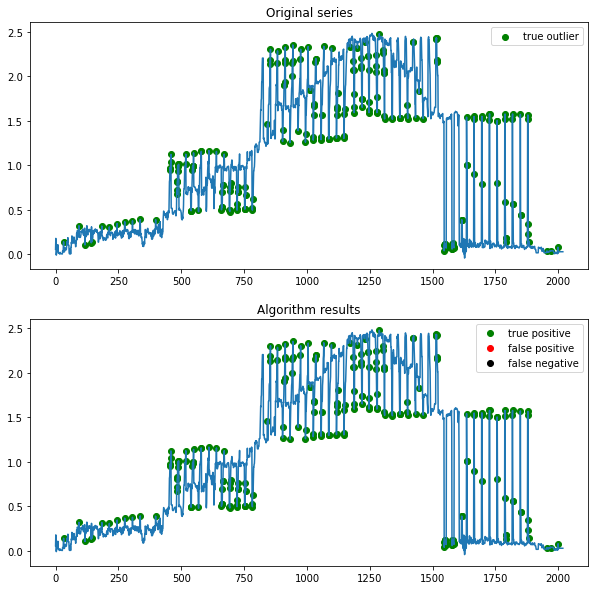

In [177]:
tp, fp, fn = evaluate_detection(V5_1['Bonos_close'], outlier_ind, detected_outliers)


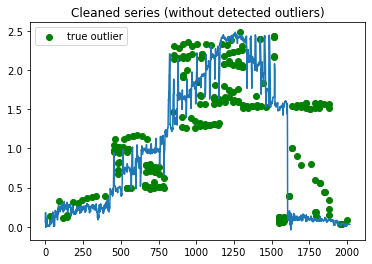

In [178]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, V5_1['Bonos_close'][outlier_ind], c='g', label='true outlier')
plt.title('Cleaned series (without detected outliers)')
plt.legend();

In [179]:
V5_1['Bonos_close'] = res

[]

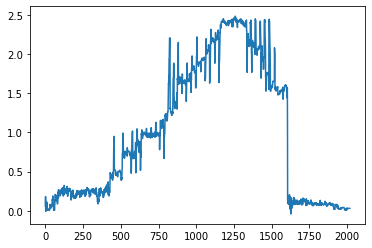

In [180]:
V5_1.Bonos_close.plot()
plt.plot()

In [185]:
V5_1.dtypes

Open Time      datetime64[ns]
Open                  float64
High                  float64
Low                   float64
Close                 float64
                    ...      
CCI_300               float64
PIB                   float64
CPI                   float64
Tarifas               float64
Bonos_close           float64
Length: 108, dtype: object

In [186]:
V5_1.tail(400)

,Open Time,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,halving,...,Momentum_300,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close
1619,2020-03-17,5035.56,5563.18,4929.59,5343.07,3.394592e+07,278326,2529.19,2425.66,1,...,-2918.93,0.626884,-0.206773,0.658137,0.513489,-2.931247,57691.0,-0.217645,0.693024,0.086
1620,2020-03-18,5343.07,5450.00,5019.72,5420.45,2.794779e+07,231254,2398.10,2436.50,1,...,-2276.93,0.633464,-0.144958,0.652599,0.502310,-2.653849,57691.0,-0.217645,0.693024,0.053
1621,2020-03-19,5420.45,6436.99,5270.00,6191.02,5.317919e+07,265689,2409.39,2393.48,1,...,-2459.47,0.640074,-0.124064,0.931324,0.500336,-2.608319,57691.0,-0.217645,0.693024,0.028
1622,2020-03-20,6191.02,6961.65,5660.77,6205.18,5.523138e+07,284594,2304.92,2431.94,1,...,-1813.34,0.644078,0.013082,0.789227,0.521081,-2.119889,57691.0,-0.217645,0.693024,0.025
1623,2020-03-21,6205.18,6464.21,5863.67,6208.45,1.998797e+07,245896,2304.92,2431.94,1,...,-1869.69,0.648099,0.019259,0.418494,0.531491,-1.889883,57691.0,-0.217645,0.693024,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2021-04-16,63158.74,63520.61,60000.00,61334.80,9.176414e+04,2639940,4185.47,4174.14,3,...,53849.75,2.784073,1.037233,0.640438,0.503987,2.155158,56812.0,0.547438,17.536664,0.030
2015,2021-04-17,61334.81,62506.05,59580.91,60006.66,5.891226e+04,2268816,4185.47,4174.14,3,...,51975.85,2.780519,1.006056,0.379139,0.503987,2.054954,56812.0,0.547438,18.691269,0.030
2016,2021-04-18,60006.67,60499.00,50931.30,56150.01,1.248821e+05,3444089,4185.47,4174.14,3,...,50711.97,2.775728,0.982559,0.145549,0.503987,1.982619,56812.0,0.547438,18.691269,0.030
2017,2021-04-19,56150.01,57526.81,54221.58,55633.14,7.822904e+04,2390527,4162.80,4175.60,3,...,46464.32,2.768782,0.924720,0.545451,0.503987,1.695163,56812.0,0.547438,18.691269,0.030


In [189]:
V5_1.to_csv('V5.csv')

In [190]:
V5_1.describe()

,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,halving,Close Gold,...,Momentum_300,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close
count,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03,2.019000e+03,2019.000000,2019.000000,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.00000,2019.000000,2019.000000,2019.000000
mean,8118.617256,8373.885953,7845.329911,8146.388430,1.738177e+07,4.597203e+05,2721.572779,2722.471773,1.340267,1447.997930,...,3789.273210,1.235777,0.647061,0.580535,0.425068,0.886094,56294.60525,0.164150,1.583540,0.985281
std,10787.222476,11161.188328,10387.891407,10839.617374,3.437011e+07,5.251333e+05,509.906876,511.101673,0.752675,212.870985,...,9761.444269,0.859003,0.448007,0.269354,0.183269,1.476583,1459.75212,0.264283,2.139628,0.859643
min,246.300000,249.500000,236.000000,247.600000,0.000000e+00,1.045500e+05,0.000000,0.000000,0.000000,0.000000,...,-13297.770000,0.000000,-0.282537,0.000000,0.000000,-2.931247,52448.00000,-0.668694,0.044267,-0.041000
25%,1049.880000,1082.560000,1022.655000,1054.860000,3.166145e+05,2.237780e+05,2341.890000,2342.610000,1.000000,1310.400000,...,0.000000,0.708860,0.275247,0.361690,0.427120,0.000000,55165.00000,0.001950,0.194322,0.165000
50%,6410.010000,6546.290000,6320.010000,6412.000000,5.270744e+06,2.838960e+05,2717.070000,2717.350000,1.000000,1369.800000,...,1057.960000,1.087076,0.686656,0.609790,0.494637,0.759409,56785.00000,0.159388,0.864764,0.776000
75%,9479.285000,9699.530000,9231.755000,9484.275000,2.003407e+07,3.529245e+05,2986.200000,2988.865000,1.000000,1541.300000,...,4501.185000,1.785808,1.015587,0.810133,0.532760,2.088887,57429.00000,0.397509,2.974081,1.766000
max,63575.010000,64854.000000,62020.000000,63575.000000,5.606539e+08,4.431451e+06,4185.470000,4175.600000,3.000000,2069.400000,...,54109.860000,3.613338,1.848980,1.000000,0.629368,5.005236,58490.00000,0.582773,21.750659,2.483000


In [191]:
gas_natural = pd.read_csv('gas_natural.csv', sep=";" , decimal=",")


In [192]:
gas_natural.describe()

,Último,Apertura,Máximo,Mínimo
count,1579.000000,1579.000000,1579.000000,1579.000000
mean,2.652171,2.654370,2.705239,2.603001
std,0.502929,0.500909,0.513152,0.490917
min,1.482000,1.441000,1.567000,1.432000
25%,2.318500,2.318500,2.364500,2.269500
50%,2.711000,2.710000,2.756000,2.665000
75%,2.939500,2.939000,2.984000,2.897500
max,4.837000,4.672000,4.929000,4.473000


In [193]:
gas_natural.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,09.04.2021,2.526,2.520,2.552,2.503,"121,59K","0,16%"
1,08.04.2021,2.522,2.510,2.535,2.478,"140,80K","0,08%"
2,07.04.2021,2.520,2.464,2.546,2.458,"132,27K","2,61%"
3,06.04.2021,2.456,2.511,2.568,2.453,"142,68K","-2,19%"
4,05.04.2021,2.511,2.593,2.616,2.488,"146,89K","-4,85%"


In [194]:
gas_natural_dep = gas_natural.drop(['Apertura','Máximo','Mínimo','Vol.','% var.'], axis=1)

In [202]:
gas_natural_dep.isna().sum()

Open Time    0
Último       0
dtype: int64

In [203]:
gas_natural_dep.dtypes

Open Time    datetime64[ns]
Último              float64
dtype: object

In [198]:
gas_natural_dep['Fecha'] = pd.to_datetime(gas_natural_dep['Fecha'])

In [201]:
gas_natural_dep.rename(columns={'Fecha':'Open Time'}, inplace=True)

In [204]:
V5_1_with_gas = V5_1.merge(gas_natural_dep[["Último", "Open Time"]], how='left', on="Open Time")


In [205]:
print(V5_1_with_gas)

      Open Time      Open      High       Low     Close         Volume  \
0    2015-10-11    246.30    249.50    246.30    249.50    3021.120000   
1    2015-10-12    249.50    249.50    247.60    247.60    9493.890000   
2    2015-10-13    247.60    252.87    245.75    250.00   12875.400000   
3    2015-10-14    250.00    254.75    250.00    253.00   30115.770000   
4    2015-10-15    253.00    258.98    253.00    255.26   50535.450000   
...         ...       ...       ...       ...       ...            ...   
2014 2021-04-16  63158.74  63520.61  60000.00  61334.80   91764.139884   
2015 2021-04-17  61334.81  62506.05  59580.91  60006.66   58912.256128   
2016 2021-04-18  60006.67  60499.00  50931.30  56150.01  124882.131824   
2017 2021-04-19  56150.01  57526.81  54221.58  55633.14   78229.042267   
2018 2021-04-20  55633.14  56599.53  53329.96  56566.46   60500.152593   

      NumberTransactions  Close SP500  Open SP500  halving  ...  \
0                 104550         0.00       

In [206]:
V5_1_with_gas.isna().sum()

Open Time        0
Open             0
High             0
Low              0
Close            0
              ... 
PIB              0
CPI              0
Tarifas          0
Bonos_close      0
Último         601
Length: 109, dtype: int64

In [54]:
V5_with_gas.drop(['Apertura', 'Máximo', 'Mínimo', '% var.', 'Fecha'], axis=1)

,Unnamed: 0,Unnamed: 0.1,Open Time,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,...,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close,Último
0,0,0,2015-10-11,246.30,249.50,246.30,249.50,3021.120000,104550,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.058,2.320
1,1,1,2015-10-12,249.50,249.50,247.60,247.60,9493.890000,134410,2052.23,...,0.000000,0.000000,1.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.180,2.015
2,2,2,2015-10-13,247.60,252.87,245.75,250.00,12875.400000,134878,2003.69,...,0.000000,0.000000,0.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.005,2.498
3,3,3,2015-10-14,250.00,254.75,250.00,253.00,30115.770000,141985,1994.24,...,0.000000,0.000000,0.596910,0.000000,0.000000,54420.0,-0.044968,0.044267,-0.008,2.518
4,4,4,2015-10-15,253.00,258.98,253.00,255.26,50535.450000,153495,2023.86,...,0.000000,0.000000,0.631579,0.000000,0.000000,54420.0,-0.044968,0.044267,0.008,2.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2014,2014,2021-04-16,63158.74,63520.61,60000.00,61334.80,91764.139884,2639940,4185.47,...,2.784073,1.037233,0.640438,0.503987,2.155158,56812.0,0.547438,17.536664,0.030,NaN
2015,2015,2015,2021-04-17,61334.81,62506.05,59580.91,60006.66,58912.256128,2268816,4185.47,...,2.780519,1.006056,0.379139,0.503987,2.054954,56812.0,0.547438,18.691269,0.030,NaN
2016,2016,2016,2021-04-18,60006.67,60499.00,50931.30,56150.01,124882.131824,3444089,4185.47,...,2.775728,0.982559,0.145549,0.503987,1.982619,56812.0,0.547438,18.691269,0.030,NaN
2017,2017,2017,2021-04-19,56150.01,57526.81,54221.58,55633.14,78229.042267,2390527,4162.80,...,2.768782,0.924720,0.545451,0.503987,1.695163,56812.0,0.547438,18.691269,0.030,NaN


In [55]:
V5_with_gas.rename(columns={'Último':'Gas_natural'}, inplace=True)

In [64]:
V5_with_gas.drop(['Apertura', 'Máximo', 'Mínimo', '% var.', 'Fecha','Unnamed: 0','Unnamed: 0.1'], axis=1)

,Open Time,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,Open SP500,halving,...,BollingerB_300,Bollinger%b_300,S0k_300,RSI_300,CCI_300,PIB,CPI,Tarifas,Bonos_close,Gas_natural
0,2015-10-11,246.30,249.50,246.30,249.50,3021.120000,104550,0.00,0.00,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.058,2.320
1,2015-10-12,249.50,249.50,247.60,247.60,9493.890000,134410,2052.23,2047.93,1,...,0.000000,0.000000,1.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.180,2.015
2,2015-10-13,247.60,252.87,245.75,250.00,12875.400000,134878,2003.69,2015.00,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,54420.0,-0.044968,0.044267,0.005,2.498
3,2015-10-14,250.00,254.75,250.00,253.00,30115.770000,141985,1994.24,2003.66,1,...,0.000000,0.000000,0.596910,0.000000,0.000000,54420.0,-0.044968,0.044267,-0.008,2.518
4,2015-10-15,253.00,258.98,253.00,255.26,50535.450000,153495,2023.86,1996.47,1,...,0.000000,0.000000,0.631579,0.000000,0.000000,54420.0,-0.044968,0.044267,0.008,2.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2021-04-16,63158.74,63520.61,60000.00,61334.80,91764.139884,2639940,4185.47,4174.14,3,...,2.784073,1.037233,0.640438,0.503987,2.155158,56812.0,0.547438,17.536664,0.030,NaN
2015,2021-04-17,61334.81,62506.05,59580.91,60006.66,58912.256128,2268816,4185.47,4174.14,3,...,2.780519,1.006056,0.379139,0.503987,2.054954,56812.0,0.547438,18.691269,0.030,NaN
2016,2021-04-18,60006.67,60499.00,50931.30,56150.01,124882.131824,3444089,4185.47,4174.14,3,...,2.775728,0.982559,0.145549,0.503987,1.982619,56812.0,0.547438,18.691269,0.030,NaN
2017,2021-04-19,56150.01,57526.81,54221.58,55633.14,78229.042267,2390527,4162.80,4175.60,3,...,2.768782,0.924720,0.545451,0.503987,1.695163,56812.0,0.547438,18.691269,0.030,NaN


In [62]:
print(V5_with_gas)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...      PIB  \
0       249.50    3

In [57]:
V5_with_gas.isna().sum()

Unnamed: 0        0
Unnamed: 0.1      0
Open Time         0
Open              0
High              0
               ... 
Apertura          0
Máximo            0
Mínimo            0
% var.            0
Gas_natural     601
Length: 116, dtype: int64

#dejamos en stand by la columna del gas natural. puesto que faltan 601 valores. valoramos a futuro, cuando estén todas las variables, rellenar con datos sintéticos 

In [65]:
V5_with_gas.tail(400)

,Unnamed: 0,Unnamed: 0.1,Open Time,Open,High,Low,Close,Volume,NumberTransactions,Close SP500,...,PIB,CPI,Tarifas,Fecha,Bonos_close,Apertura,Máximo,Mínimo,% var.,Gas_natural
1619,1619,1619,2020-03-17,5035.56,5563.18,4929.59,5343.07,3.394592e+07,278326,2529.19,...,57691.0,-0.217645,0.693024,2020-03-17,0.086,0.239,0.341,0.086,"-57,64%",1.729
1620,1620,1620,2020-03-18,5343.07,5450.00,5019.72,5420.45,2.794779e+07,231254,2398.10,...,57691.0,-0.217645,0.693024,2020-03-18,0.053,0.102,0.173,0.028,"-38,37%",1.604
1621,1621,1621,2020-03-19,5420.45,6436.99,5270.00,6191.02,5.317919e+07,265689,2409.39,...,57691.0,-0.217645,0.693024,2020-03-19,0.028,0.137,0.188,0.025,"-47,17%",1.654
1622,1622,1622,2020-03-20,6191.02,6961.65,5660.77,6205.18,5.523138e+07,284594,2304.92,...,57691.0,-0.217645,0.693024,2020-03-20,0.025,0.025,0.031,0.025,"-10,71%",1.604
1623,1623,1623,2020-03-21,6205.18,6464.21,5863.67,6208.45,1.998797e+07,245896,2304.92,...,57691.0,-0.217645,0.693024,2020-03-20,0.025,0.025,0.031,0.025,"-10,71%",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2014,2014,2021-04-16,63158.74,63520.61,60000.00,61334.80,9.176414e+04,2639940,4185.47,...,56812.0,0.547438,17.536664,2021-04-04,0.030,0.030,0.030,0.030,"49,75%",NaN
2015,2015,2015,2021-04-17,61334.81,62506.05,59580.91,60006.66,5.891226e+04,2268816,4185.47,...,56812.0,0.547438,18.691269,2021-04-04,0.030,0.030,0.030,0.030,"49,75%",NaN
2016,2016,2016,2021-04-18,60006.67,60499.00,50931.30,56150.01,1.248821e+05,3444089,4185.47,...,56812.0,0.547438,18.691269,2021-04-04,0.030,0.030,0.030,0.030,"49,75%",NaN
2017,2017,2017,2021-04-19,56150.01,57526.81,54221.58,55633.14,7.822904e+04,2390527,4162.80,...,56812.0,0.547438,18.691269,2021-04-04,0.030,0.030,0.030,0.030,"49,75%",NaN


In [224]:
indice_mercado_shanghai = pd.read_csv('indice_mercado_shanghai.csv',  sep=";" , decimal=",")




In [225]:
print(indice_mercado_shanghai)

           Fecha    Último  Apertura    Máximo    Mínimo    Vol.  % var.
0     09.04.2021  3.450,68  3.475,44  3.475,45  3.442,14  28,01B  -0,92%
1     08.04.2021  3.482,55  3.467,49  3.495,91  3.459,32  33,18B   0,08%
2     07.04.2021  3.479,63  3.483,42  3.483,42  3.453,19  29,58B  -0,10%
3     06.04.2021  3.482,97  3.491,63  3.493,28  3.471,76  23,47B  -0,04%
4     02.04.2021  3.484,39  3.472,63  3.487,59  3.462,83  26,27B   0,52%
...          ...       ...       ...       ...       ...     ...     ...
1457  17.04.2015  4.287,30  4.254,72  4.317,22  4.238,91  70,17B   2,20%
1458  16.04.2015  4.194,82  4.055,92  4.195,31  4.031,24  55,12B   2,71%
1459  15.04.2015  4.084,16  4.135,65  4.175,49  4.069,01  61,30B  -1,24%
1460  14.04.2015  4.135,57  4.125,78  4.168,35  4.091,26  61,07B   0,34%
1461  13.04.2015  4.121,71  4.072,72  4.128,07  4.057,29  58,98B   2,17%

[1462 rows x 7 columns]


In [226]:
indice_mercado_shanghai.describe()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,1462,1462,1462,1462,1462,1462,1462
unique,1462,1451,1450,1456,1449,1158,494
top,28.03.2019,"3.052,78","3.381,49","3.219,52","3.100,39","16,01B","0,07%"
freq,1,3,2,2,2,5,14


In [250]:
ind_shanghai = indice_mercado_shanghai.drop(['Apertura', 'Máximo', 'Mínimo', '% var.', 'Vol.'], axis=1)

In [252]:
index_shanghai = ind_shanghai.rename(columns={'index_shangay':'index_shanghai'}, inplace=True)

In [255]:
print(ind_shanghai)

       Open Time index_shanghai
0     09.04.2021       3.450,68
1     08.04.2021       3.482,55
2     07.04.2021       3.479,63
3     06.04.2021       3.482,97
4     02.04.2021       3.484,39
...          ...            ...
1457  17.04.2015       4.287,30
1458  16.04.2015       4.194,82
1459  15.04.2015       4.084,16
1460  14.04.2015       4.135,57
1461  13.04.2015       4.121,71

[1462 rows x 2 columns]


In [ ]:
ind_shanghai = indice_mercado_shanghai.drop(['Apertura', 'Máximo', 'Mínimo', '% var.', 'Vol.'], axis=1)

In [254]:
ind_shanghai.rename(columns={'Fecha':'Open Time'}, inplace=True)

In [261]:
V5_with_gas.dtypes

Unnamed: 0               int64
Unnamed: 0.1             int64
Open Time       datetime64[ns]
Open                   float64
High                   float64
                     ...      
Apertura               float64
Máximo                 float64
Mínimo                 float64
% var.                  object
Gas_natural            float64
Length: 116, dtype: object

In [260]:
ind_shanghai.dtypes

Open Time         datetime64[ns]
index_shanghai            object
dtype: object

In [258]:
ind_shanghai['Open Time'] = pd.to_datetime(ind_shanghai['Open Time'])

In [265]:
V6 = V5_with_gas.merge(ind_shanghai[["index_shanghai", "Open Time"]], how="left", on="Open Time")


In [266]:
print(V6)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...       CPI  \
0       249.50    

In [267]:
V6.isna().sum()
#DEJAMOS EN STAND BY LAS VARIABLES DE GAS NATURAL Y DE INDEX SHANGAI. TRAS EL ACOPLE DE TODAS LAS VARIABLES, VALORAMOS QUÉ RELLENAMOS CON SINTÉTICAS. 


Unnamed: 0          0
Unnamed: 0.1        0
Open Time           0
Open                0
High                0
                 ... 
Máximo              0
Mínimo              0
% var.              0
Gas_natural       601
index_shanghai    704
Length: 117, dtype: int64

In [272]:
precios_petroleo = pd.read_csv('precios_petroleo.csv ',  sep=";" , decimal=",")





In [273]:
print(precios_petroleo)

           Fecha     Último   Apertura     Máximo     Mínimo     Vol.  % var.
0     09.04.2021  33.800,60  33.526,19  33.810,87  33.526,19  317,82M   0,89%
1     08.04.2021  33.503,57  33.469,89  33.506,80  33.342,64  306,19M   0,17%
2     07.04.2021  33.446,26  33.444,98  33.521,76  33.347,96  279,88M   0,05%
3     06.04.2021  33.430,24  33.500,02  33.544,79  33.380,43  298,31M  -0,29%
4     05.04.2021  33.527,19  33.222,38  33.617,95  33.222,38  345,15M   1,13%
...          ...        ...        ...        ...        ...      ...     ...
1505  17.04.2015  17.826,30  18.102,56  18.102,56  17.748,53  138,86M  -1,54%
1506  16.04.2015  18.105,77  18.106,27  18.169,26  18.063,86   89,52M  -0,04%
1507  15.04.2015  18.112,61  18.045,71  18.160,52  18.045,71  113,61M   0,42%
1508  14.04.2015  18.036,70  17.979,11  18.075,60  17.905,48   82,83M   0,33%
1509  13.04.2015  17.977,04  18.052,32  18.107,57  17.974,81  120,09M  -0,45%

[1510 rows x 7 columns]


In [274]:
precios_petroleo.describe()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,1510,1510,1510,1510,1510,1510,1510
unique,1510,1508,1508,1510,1509,1477,416
top,28.03.2019,"27.691,49","17.924,24","30.343,59","25.657,78","123,43M","-0,29%"
freq,1,2,2,1,2,2,17


In [284]:
pr_petroleo = precios_petroleo.drop(['Apertura', 'Máximo', 'Mínimo', '% var.', 'Vol.'], axis=1)

In [285]:
pr_petroleo.describe()

,Fecha,Último
count,1510,1510
unique,1510,1508
top,28.03.2019,"27.691,49"
freq,1,2


In [290]:
print(pr_petroleo)

       Open Time Ind_Petroleo
0     09.04.2021    33.800,60
1     08.04.2021    33.503,57
2     07.04.2021    33.446,26
3     06.04.2021    33.430,24
4     05.04.2021    33.527,19
...          ...          ...
1505  17.04.2015    17.826,30
1506  16.04.2015    18.105,77
1507  15.04.2015    18.112,61
1508  14.04.2015    18.036,70
1509  13.04.2015    17.977,04

[1510 rows x 2 columns]


In [289]:
pr_petroleo.rename(columns={'Fecha':'Open Time','Último':'Ind_Petroleo'}, inplace=True)

In [292]:
pr_petroleo.dtypes

Open Time       object
Ind_Petroleo    object
dtype: object

In [293]:
pr_petroleo['Open Time'] = pd.to_datetime(pr_petroleo['Open Time'])

In [294]:
V7 = V6.merge(pr_petroleo[["Ind_Petroleo", "Open Time"]], how="left", on="Open Time")

In [295]:
print(V7)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...  \
0       249.50    3021.12000

In [365]:
V7.isna().sum()

Unnamed: 0          0
Unnamed: 0.1        0
Open Time           0
Open                0
High                0
                 ... 
Mínimo              0
% var.              0
Gas_natural       601
index_shanghai    704
Ind_Petroleo      665
Length: 118, dtype: int64

In [366]:
euro = pd.read_csv('Datos historicos EUR_USD.OK.csv',  sep=";" , decimal=",")

In [368]:
print(euro)

           Fecha  Último  Apertura  Máximo  Mínimo  % var.
0     30.04.2021  1.2028    1.2125  1.2127  1.2024  -0,80%
1     29.04.2021  1.2125    1.2135  1.2150  1.2103  -0,09%
2     28.04.2021  1.2135    1.2090  1.2136  1.2056   0,38%
3     27.04.2021  1.2090    1.2079  1.2093  1.2056   0,08%
4     26.04.2021  1.2079    1.2090  1.2117  1.2061  -0,16%
...          ...     ...       ...     ...     ...     ...
1585  03.04.2015  1.0978    1.0883  1.1028  1.0864   0,86%
1586  02.04.2015  1.0884    1.0764  1.0905  1.0751   1,11%
1587  01.04.2015  1.0764    1.0735  1.0801  1.0719   0,31%
1588  31.03.2015  1.0731    1.0833  1.0846  1.0713  -0,95%
1589  30.03.2015  1.0834    1.0889  1.0897  1.0811  -0,50%

[1590 rows x 6 columns]


In [369]:
euro.describe()

,Último,Apertura,Máximo,Mínimo
count,1590.000000,1590.000000,1590.000000,1590.000000
mean,1.135553,1.135452,1.139864,1.131341
std,0.045533,0.045550,0.045427,0.045667
min,1.038700,1.038900,1.041900,1.034100
25%,1.103425,1.103225,1.108325,1.099825
50%,1.126850,1.126800,1.131850,1.122150
75%,1.172700,1.172725,1.176800,1.168200
max,1.251000,1.250800,1.255700,1.244700


In [372]:
euro.dtypes

Fecha        object
Último      float64
Apertura    float64
Máximo      float64
Mínimo      float64
% var.       object
dtype: object

In [373]:
euro['Fecha'] = pd.to_datetime(euro['Fecha'])

In [374]:
euro.rename(columns={'Último':'Euro'}, inplace=True)

In [375]:
euro_1 = euro.drop(['Apertura', 'Máximo', 'Mínimo', '% var.'], axis=1)

In [377]:
euro_1.dtypes

Fecha    datetime64[ns]
Euro            float64
dtype: object

In [380]:
euro_1.rename(columns={'Fecha':'Open Time'}, inplace=True)

In [381]:
print(euro_1)

      Open Time    Euro
0    2021-04-30  1.2028
1    2021-04-29  1.2125
2    2021-04-28  1.2135
3    2021-04-27  1.2090
4    2021-04-26  1.2079
...         ...     ...
1585 2015-03-04  1.0978
1586 2015-02-04  1.0884
1587 2015-01-04  1.0764
1588 2015-03-31  1.0731
1589 2015-03-30  1.0834

[1590 rows x 2 columns]


In [382]:
V8 = V7.merge(euro_1[["Euro", "Open Time"]], how="left", on="Open Time")

In [383]:
print(V8)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...  \
0       249.50    3021.12000

In [384]:
V8.isna().sum()

Unnamed: 0          0
Unnamed: 0.1        0
Open Time           0
Open                0
High                0
                 ... 
% var.              0
Gas_natural       601
index_shanghai    704
Ind_Petroleo      665
Euro              607
Length: 119, dtype: int64

In [386]:
yen = pd.read_csv('Datos historicos USD_JPY.OK.csv',  sep=";" , decimal=",")

In [387]:
print(yen)

           Fecha  Último  Apertura  Máximo  Mínimo  % var.
0     30.04.2021  109.31    108.90  109.35  108.71   0,37%
1     29.04.2021  108.90    108.50  109.22  108.43   0,37%
2     28.04.2021  108.50    108.75  109.08  108.50  -0,23%
3     27.04.2021  108.75    108.21  108.78  108.11   0,51%
4     26.04.2021  108.21    107.89  108.21  107.64   0,27%
...          ...     ...       ...     ...     ...     ...
1585  03.04.2015  118.97    119.71  119.80  118.69  -0,63%
1586  02.04.2015  119.72    119.76  119.91  119.42  -0,04%
1587  01.04.2015  119.77    120.10  120.34  119.40  -0,31%
1588  31.03.2015  120.14    120.06  120.38  119.76   0,05%
1589  30.03.2015  120.08    119.12  120.23  119.09   0,79%

[1590 rows x 6 columns]


In [388]:
yen.describe()

,Último,Apertura,Máximo,Mínimo
count,1590.000000,1590.000000,1590.000000,1590.000000
mean,110.819208,110.818157,111.216113,110.382478
std,5.327712,5.319606,5.342810,5.305122
min,99.890000,99.890000,100.410000,99.120000
25%,107.285000,107.300000,107.667500,106.932500
50%,109.970000,109.970000,110.320000,109.575000
75%,112.935000,112.940000,113.390000,112.550000
max,125.620000,125.580000,125.860000,124.520000


In [389]:
yen.dtypes

Fecha        object
Último      float64
Apertura    float64
Máximo      float64
Mínimo      float64
% var.       object
dtype: object

In [390]:
yen['Fecha'] = pd.to_datetime(yen['Fecha'])

In [391]:
yen.rename(columns={'Fecha':'Open Time','Último':'Yen'}, inplace=True)

In [392]:
yen_1 = yen.drop(['Apertura', 'Máximo', 'Mínimo', '% var.'], axis=1)

In [393]:
yen_1.describe()

,Yen
count,1590.000000
mean,110.819208
std,5.327712
min,99.890000
25%,107.285000
50%,109.970000
75%,112.935000
max,125.620000


In [394]:
print(yen_1)

      Open Time     Yen
0    2021-04-30  109.31
1    2021-04-29  108.90
2    2021-04-28  108.50
3    2021-04-27  108.75
4    2021-04-26  108.21
...         ...     ...
1585 2015-03-04  118.97
1586 2015-02-04  119.72
1587 2015-01-04  119.77
1588 2015-03-31  120.14
1589 2015-03-30  120.08

[1590 rows x 2 columns]


In [395]:
V9 = V8.merge(yen_1[["Yen", "Open Time"]], how="left", on="Open Time")

In [396]:
print(V9)

      Unnamed: 0  Unnamed: 0.1  Open Time      Open      High       Low  \
0              0             0 2015-10-11    246.30    249.50    246.30   
1              1             1 2015-10-12    249.50    249.50    247.60   
2              2             2 2015-10-13    247.60    252.87    245.75   
3              3             3 2015-10-14    250.00    254.75    250.00   
4              4             4 2015-10-15    253.00    258.98    253.00   
...          ...           ...        ...       ...       ...       ...   
2014        2014          2014 2021-04-16  63158.74  63520.61  60000.00   
2015        2015          2015 2021-04-17  61334.81  62506.05  59580.91   
2016        2016          2016 2021-04-18  60006.67  60499.00  50931.30   
2017        2017          2017 2021-04-19  56150.01  57526.81  54221.58   
2018        2018          2018 2021-04-20  55633.14  56599.53  53329.96   

         Close         Volume  NumberTransactions  Close SP500  ...  \
0       249.50    3021.12000

In [397]:
V9.isna().sum()

Unnamed: 0          0
Unnamed: 0.1        0
Open Time           0
Open                0
High                0
                 ... 
Gas_natural       601
index_shanghai    704
Ind_Petroleo      665
Euro              607
Yen               607
Length: 120, dtype: int64

In [400]:
V9.to_csv('V9.csv')